# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import george

from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


In [2]:
tab['quarter'==6]

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6


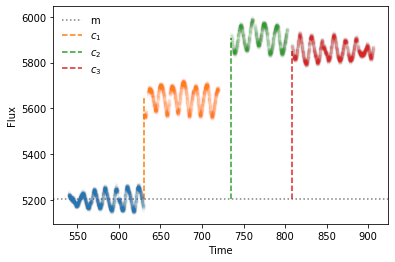

In [3]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [30]:
from george import kernels

A0,g0,p0,l0=200,1,5,0.1

k1=A0*kernels.ExpSine2Kernel(gamma=g0, log_period=p0)
k2=kernels.ExpSquaredKernel(metric=l0)

kernel=kernels.Product(k1,k2)

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

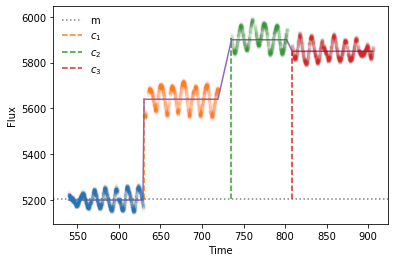

In [31]:
from george.modeling import Model

class MeanModel(Model):
    parameter_names=("m","c1","c2","c3")
    
    def get_value(self,t):
        quarter_values=np.unique(tab['quarter'])
        
        quarter_ind=[]
        
        for q in quarter_values:
            ind=(tab['quarter']==q)
            quarter_ind.append(np.argmin(np.abs(t-tab['time'][ind].max())))
            
        flux=np.zeros(len(t))    
        
        flux[0:quarter_ind[0]+1]=self.m
        flux[quarter_ind[0]+1:quarter_ind[1]+1]=self.m+self.c1
        flux[quarter_ind[1]+1:quarter_ind[2]+1]=self.m+self.c2
        flux[quarter_ind[2]+1:quarter_ind[3]+1]=self.m+self.c3
        
        return flux
        
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)

# guesses based on plot and model function
m0,c10,c20,c30=5200,440,700,650

plt.plot(tab['time'][::20],MeanModel(m=m0,c1=c10,c2=c20,c3=c30).get_value(tab['time'][::20]))

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [32]:
def lnprob(p):
    model.set_parameter_vector(p) 
    return -model.lnlikelihood(tab["flux"][::10], quiet=True)

In [33]:
import scipy.optimize as op
#model = george.GP(kernel=kernel,mean=m0)
global model

model = george.GP(kernel = kernel, mean = MeanModel(m0, c10, c20, c30))
model.compute(tab["time"][::10])
print('model complete')

p0 = model.get_parameter_vector()
results = op.minimize(lnprob, p0, method="L-BFGS-B")
print('optimization complete')

t_new = np.linspace(550,900, len(tab["flux"][::10]))

ypred, cov = model.predict(tab["flux"][::10], t_new, return_cov = True)
std = np.sqrt(np.diag(cov))

model complete
optimization complete


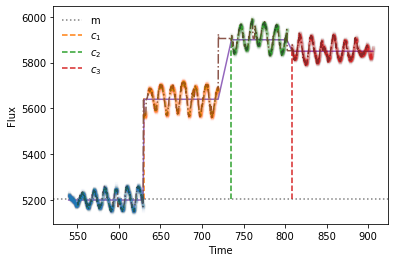

In [34]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)

# guesses based on plot and model function
m0,c10,c20,c30=5200,440,700,650

plt.plot(tab['time'][::10],MeanModel(m=m0,c1=c10,c2=c20,c3=c30).get_value(tab['time'][::10]))

plt.plot(t_new,ypred,ls='-.')

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [35]:
import emcee

# Set up the sampler.
nwalkers, ndim = 16, len(model)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = model.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim)

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 100)

print("Running production chain")
sampler.run_mcmc(p0, 200);

Running burn-in
Running production chain


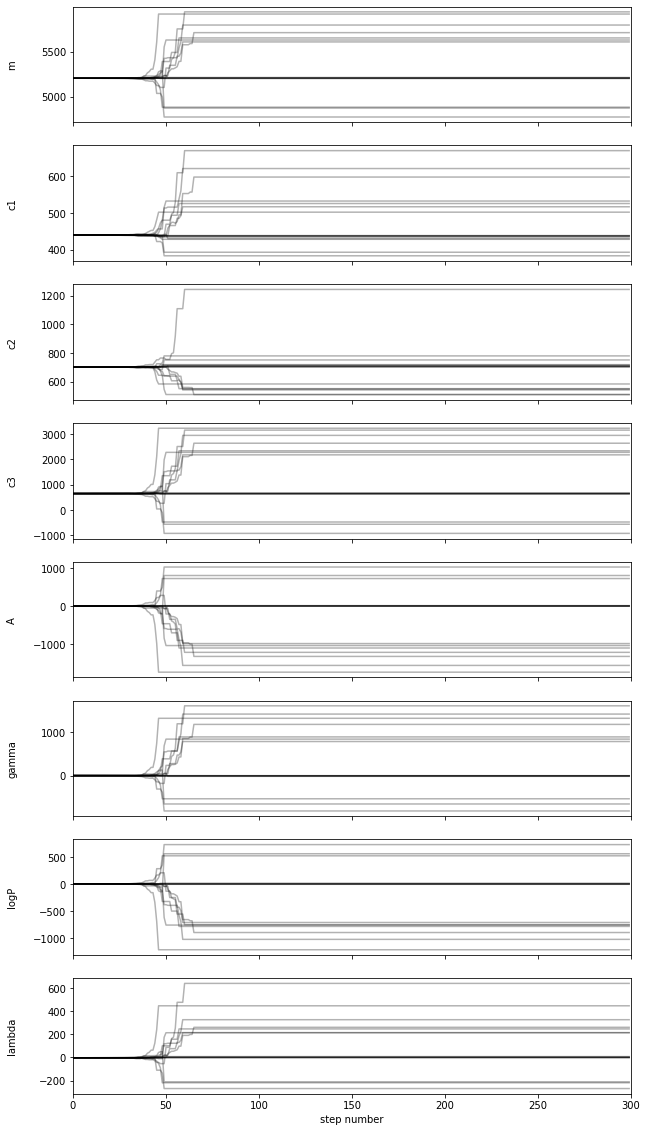

In [36]:
fig, axes = plt.subplots(nrows=8,figsize=(10,20), sharex=True)
samples = sampler.get_chain()
labels = ['m','c1','c2','c3','A','gamma','logP','lambda']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

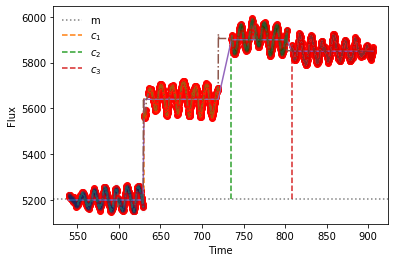

In [37]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)

# guesses based on plot and model function
m0,c10,c20,c30=5200,440,700,650

plt.plot(tab['time'][::10],tab['flux'][::10],'ro')

plt.plot(tab['time'][::10],MeanModel(m=m0,c1=c10,c2=c20,c3=c30).get_value(tab['time'][::10]))

plt.plot(t_new,ypred,ls='-.')

why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why
why


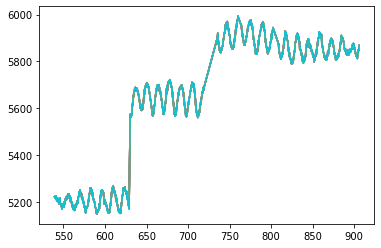

In [49]:
for i in range(50):    
    try:
        w = np.random.randint(sampler.chain.shape[0])
        n = np.random.randint(sampler.chain.shape[1])
        model.set_parameter_vector(sampler.chain[w, n])
        plt.plot(tab['time'][::10], model.sample_conditional(tab['flux'][::10], tab['time'][::10]))
    
    except:
        print('why')